In [1]:
from contextlib import suppress
import matplotlib
import matplotlib.pyplot as plt

import numpy as np
import os
import warnings
from zipfile import ZipFile

from skimage.io import imread, imsave

from keras import applications
from keras import optimizers
from keras.models import Sequential
from keras.layers import Activation, Dense, Dropout, Flatten
from keras.utils import to_categorical
from keras.preprocessing.image import ImageDataGenerator

from sklearn.metrics import accuracy_score, classification_report

%matplotlib inline

Using TensorFlow backend.


### data preparation

['landing', 'phase1-vegitative', 'phase2-reproduction', 'phase3-ripening']


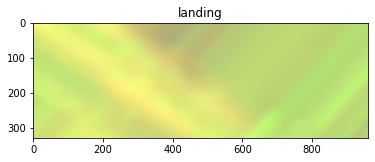

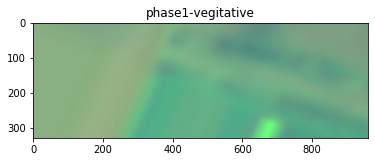

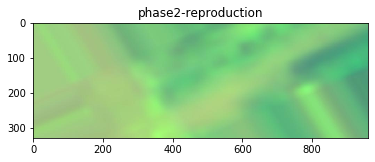

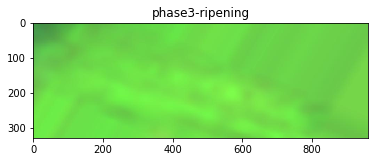

In [17]:
#see the first image in each classes

root = './cnn-dataset'

classes = [direc for direc in os.listdir(root) if os.path.isdir(os.path.join(root,direc)) and direc != 'flow']
print(classes)
for i, _class in enumerate(classes):
    plt.imshow(imread(os.path.join(root, _class, os.listdir(os.path.join(root,_class))[0])))
    plt.axis('on')
    plt.title(_class)
    plt.show()


In [18]:
# Set random seed for reproducibility
np.random.seed(8)

### randomly assigned each augmented image to train, test, validation folder separated by class name 

In [20]:
%%time
"""
Create image directory hierarchy that looks like this:
./cnn-dataset/flow/
            train/
                  langing/
                  phase-1/
                  ...
            validate/
                    langing/
                  phase-1/
                  ...
            test/
                 langing/
                  phase-1/
                  ...
"""

root = './cnn-dataset'
# classes name
classes = [direc for direc in os.listdir(root) if os.path.isdir(os.path.join(root,direc))]

# base directory flow pathname
flow_base = os.path.join(root, 'flow')

# target directory pathname
target_dirs = {target: os.path.join(flow_base, target) for target in ['train', 'validate', 'test']}

if not os.path.isdir(flow_base):
    # new directory
    os.mkdir(flow_base)
    
    # created target folder and class folder
    for target in ['train', 'validate', 'test']:
        target_direc = os.path.join(flow_base, target)
        os.mkdir(target_direc)
        
        for _class in classes:
            class_direc = os.path.join(target_direc,_class)
            os.mkdir(class_direc)
    # suppress low-contrast warning from skimage.io.imsave
    warnings.simplefilter('ignore', UserWarning)   
    
    # Copy images from ./data/UCMerced_LandUse/Images to ./data/flow/<train, validate, test> 
    for _root, dirnames, filenames in os.walk(root):
        if filenames:
            classname = os.path.basename(_root)
            
            # shuffling the file name
            filenames = np.random.permutation(filenames)
        
            for target, count in [('train', 440), ('validate', 55), ('test', 55)]:
                target_dir = os.path.join(flow_base, target, classname)
                
                for filename in filenames[:count]:
                    filepath = os.path.join(_root, filename)
                    image = imread(filepath)
                    basename, _ = os.path.splitext(filename)
                    target_filename = os.path.join(target_dir, filename)
                    imsave(target_filename, image)
                    
                filenames = filenames[count:]
                    
    # Show future warnings during development
    warnings.resetwarnings()

Wall time: 1min 32s


## get bottleneck feature extraction

In [21]:
def extract_bottleneck_features(model, dataset, preprocessing_fn, bs=64):
    '''
    get the bottleneck feature from X and Y of (train/validation/test) dataset
    by convolutional part only
    
    input:
        model: pre-trained model(VGG16) without FC part
        dataset: [train/validation/test]
        preprocessing_fn: function that preprocess each input sample
        bs: batch size
        
    return:
        bottleneck feature of np.array
    '''
    
    print(f'Generating "{dataset}" bottleneck predictions')
    X_filepath = os.path.join('cnn-dataset', 'bn_' + dataset + '_X.npy')
    y_filepath = os.path.join('cnn-dataset', 'bn_' + dataset + '_y.npy')
    
    # Check if data are available from disk.
    try:
        with open(X_filepath, 'rb') as f:
            X = np.load(f)
        with open(y_filepath, 'rb') as f:
            y = np.load(f)
            Y = to_categorical(y, num_classes=len(np.unique(y)))
    # Else, get the bottleneck features and labels
    except:
        image_data_gen = ImageDataGenerator(rescale=1/255.0, preprocessing_function=preprocessing_fn)
        image_generator = image_data_gen.flow_from_directory(target_dirs[dataset],
                                                             batch_size=bs,
                                                             shuffle=False
                                                             )
        
    image_count = 0
    X_batches, Y_batches = [], []
    for X, Y in image_generator:
        X_batches.append(model.predict_on_batch(X))
        Y_batches.append(Y)
        image_count += X.shape[0]
        # Must interrupt image_generator
        if image_count >= image_generator.n:
            break
    

    X = np.concatenate(X_batches)
    with open(X_filepath, 'wb') as f:
        np.save(f, X) 
    Y = np.concatenate(Y_batches)
    y = np.nonzero(Y)[1]
    with open(y_filepath, 'wb') as f:
        np.save(f, y)
        
    print(f'   Features of shape {X.shape} extracted for model "{model.name}"')
    return X, Y

In [22]:
# Let's try the VGG16 model
pretrained_model = applications.VGG16(include_top=False, weights='imagenet')

InternalError: cudaGetDevice() failed. Status: cudaGetErrorString symbol not found.